<h1 align="center">Classifying images from CIFAR100 using ResNet</h1>

### About dataset
The dataset is a collection of images of different objects separated in 20 folder as their classes.

### Content
The training dataset contains `50,000` and the test dataset contains `10,000` images of different objects. All the images have `3` channels (RGB) and the shape of the images are `32x32` pixels.

### Acknowledgements
- CIFAR100 dataset link - https://github.com/zalandoresearch/fashion-mnist


In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:

train_transfrom =  tt.Compose([tt.RandomCrop(28, padding=4, padding_mode="reflect"),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize((0.5,),(0.5,),)
                         ])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize((0.5,),(0.5,),)])

# Download dataset
train_ds = FashionMNIST(root='data/FashionMINST', download=True, transform = train_transfrom)
valid_ds =FashionMNIST(root='data/FashionMINST', train=False, transform = valid_tfms)

In [3]:
batch_size = 400

#Python data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, pin_memory=True)
len(train_ds), len(valid_ds)

(60000, 10000)

In [4]:
img, label = train_ds[0]
img.shape

torch.Size([1, 28, 28])

### View batch images

In [5]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,1,1,1)
  stds = torch.tensor(stds).reshape(1,1,1,1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_image = denormalize(images, 0.5, 0.5)
    ax.imshow(make_grid(denorm_image[:64], nrow=8).permute(1,2,0).clamp(0,1))
    break

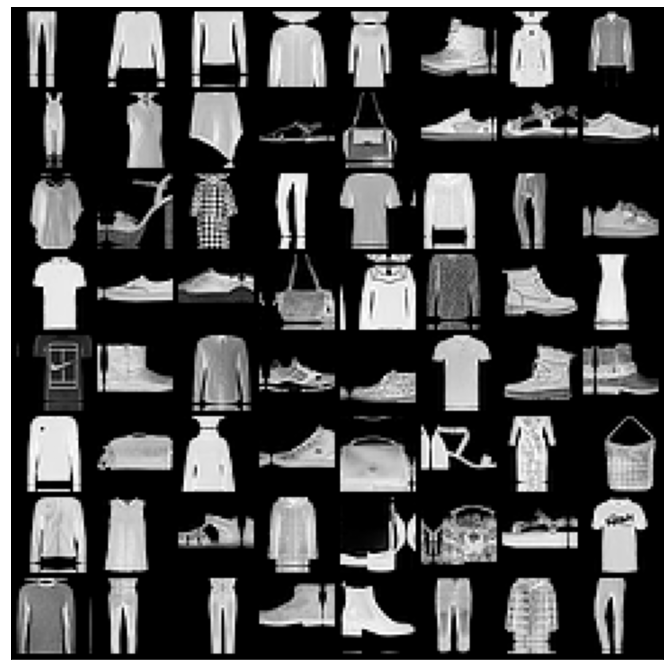

In [6]:
show_batch(train_dl)

## Using a GPU
To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [8]:
# Move data to the selected device
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

Base image classification model 

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

ResNet9 model for image classification

In [10]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Flatten(), 
            nn.Linear(256*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [11]:
model = to_device(Cifar10CnnModel(), device)
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=12544, out_features=1024, bias=True)
    (16): ReLU()
    (17): Linear(in_features=1024, out_features=512, bias=True)
    (18): ReLU()
    (19): Linear(in_feature

## Training the model

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [13]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.10096153616905212, 'val_loss': 2.3029205799102783}]

In [14]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [15]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00104, train_loss: 1.0802, val_loss: 0.6179, val_acc: 0.7645
Epoch [1], last_lr: 0.00279, train_loss: 0.6421, val_loss: 0.5747, val_acc: 0.7815
Epoch [2], last_lr: 0.00519, train_loss: 0.5839, val_loss: 0.4572, val_acc: 0.8266
Epoch [3], last_lr: 0.00760, train_loss: 0.4742, val_loss: 0.3797, val_acc: 0.8618
Epoch [4], last_lr: 0.00936, train_loss: 0.4286, val_loss: 0.3785, val_acc: 0.8679
Epoch [5], last_lr: 0.01000, train_loss: 0.4312, val_loss: 0.3662, val_acc: 0.8655
Epoch [6], last_lr: 0.00987, train_loss: 0.3976, val_loss: 0.3593, val_acc: 0.8686
Epoch [7], last_lr: 0.00950, train_loss: 0.3597, val_loss: 0.3228, val_acc: 0.8821
Epoch [8], last_lr: 0.00891, train_loss: 0.3410, val_loss: 0.3607, val_acc: 0.8676
Epoch [9], last_lr: 0.00812, train_loss: 0.3215, val_loss: 0.2934, val_acc: 0.8944
Epoch [10], last_lr: 0.00717, train_loss: 0.3082, val_loss: 0.2758, val_acc: 0.8975
Epoch [11], last_lr: 0.00611, train_loss: 0.2802, val_loss: 0.2688, val_acc: 0.9010
Ep

### Plotting the training informations

In [16]:
# Plot accuracy for epochs
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

# plot train and validation in a single plot
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

# Plot learning rate
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

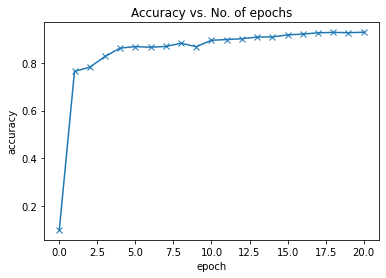

In [17]:
plot_accuracies(history)

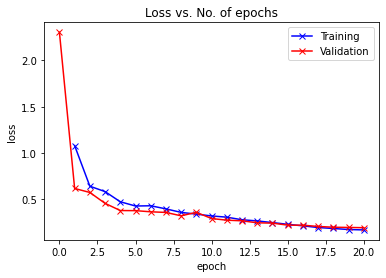

In [18]:
plot_losses(history)

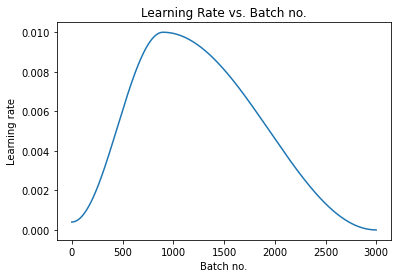

In [19]:
plot_lrs(history)

## Testing with individual images

In [20]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


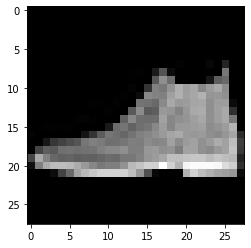

In [21]:
img, label = valid_ds[0]
plt.imshow(img[0], cmap='gray')
print("Label:", train_ds.classes[label], ", Predicted:", 
      train_ds.classes[predict_image(img, model)])

Label: T-shirt/top , Predicted: Shirt


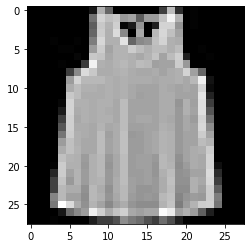

In [22]:
img, label = valid_ds[1005]
plt.imshow(img[0], cmap='gray')
print("Label:", train_ds.classes[label], ", Predicted:", 
      train_ds.classes[predict_image(img, model)])

Label: Trouser , Predicted: Trouser


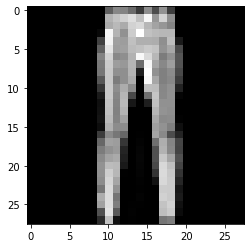

In [23]:
img, label = valid_ds[4008]
plt.imshow(img[0], cmap='gray')
print("Label:", train_ds.classes[label], ", Predicted:", 
      train_ds.classes[predict_image(img, model)])

## Save and Upload

In [24]:
torch.save(model.state_dict(), 'fashionMINST-cnn.pth')

## Conclusion and Further Work
- The model can now detect object from FashionMINST Dataset.
- 93% Accuracy is achived in 9 min 45s.
- This is a project for the assignment of Deep learning Course on Jovian.
- As the loss graph isn't showing any overfitting, we can increase it's accuracy by running more epochs.